
cos関数にノイズを加えたものを訓練用データとし、未来の値を予測させる。


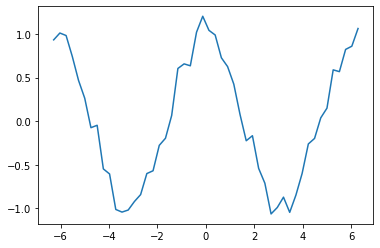

(40, 10, 1)
(40, 1)


In [11]:
#訓練用データの作成

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

x_data = np.linspace(-2*np.pi, 2*np.pi)  # -2πから2πまで
cos_data = np.cos(x_data) + 0.1*np.random.randn(len(x_data))  # cos関数に乱数でノイズを加える

plt.plot(x_data, cos_data)
plt.show()

n_rnn = 10  # 時系列の数
n_sample = len(x_data)-n_rnn  # サンプル数
x = np.zeros((n_sample, n_rnn))  # 入力
t = np.zeros((n_sample,))  # 正解、最後の時刻のみ

for i in range(0, n_sample):
    x[i] = cos_data[i:i+n_rnn]
    t[i] = cos_data[i+n_rnn]  # 入力の時系列より一つ後の値

x = x.reshape(n_sample, n_rnn, 1)  # （サンプル数、時系列の数、入力層のニューロン数）
print(x.shape)
t = t.reshape(n_sample, 1)  # （サンプル数、入力層のニューロン数）
print(t.shape)

In [12]:
#LSTMとGRUの比較

from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU

batch_size = 8  # バッチサイズ
n_in = 1  # 入力層のニューロン数
n_mid = 20  # 中間層のニューロン数
n_out = 1  # 出力層のニューロン数

# 比較のためのLSTM
model_lstm = Sequential()
model_lstm.add(LSTM(n_mid, input_shape=(n_rnn, n_in), return_sequences=False))  # 最後の出力のみ使用
model_lstm.add(Dense(n_out, activation="linear"))
model_lstm.compile(loss="mean_squared_error", optimizer="sgd")
print(model_lstm.summary())

# GRU
model_gru = Sequential()
model_gru.add(GRU(n_mid, input_shape=(n_rnn, n_in), return_sequences=False))
model_gru.add(Dense(n_out, activation="linear"))
model_gru.compile(loss="mean_squared_error", optimizer="sgd")
print(model_gru.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 20)                1760      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_4 (GRU)                  (None, 20)                1320      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 21        
Total params: 1,341
Trainable params: 1,341
Non-trainable params: 0
_________________________________________________________________
None


In [13]:
#学習

import time

epochs = 300

# LSTM
start_time = time.time()
history_lstm = model_lstm.fit(x, t, epochs=epochs, batch_size=batch_size, verbose=0)
print("学習時間 --LSTM--:", time.time() - start_time)

# GRU
start_time = time.time()
history_gru = model_gru.fit(x, t, epochs=epochs, batch_size=batch_size, verbose=0)
print("学習時間 --GRU--:", time.time() - start_time)

学習時間 --LSTM--: 9.119598627090454
学習時間 --GRU--: 10.307421684265137


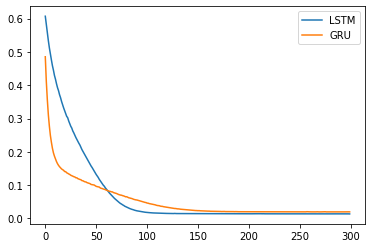

In [14]:
#誤差の推移

loss_lstm = history_lstm.history['loss']
loss_gru = history_gru.history['loss']

plt.plot(np.arange(len(loss_lstm)), loss_lstm, label="LSTM")
plt.plot(np.arange(len(loss_gru)), loss_gru, label="GRU")
plt.legend()
plt.show()

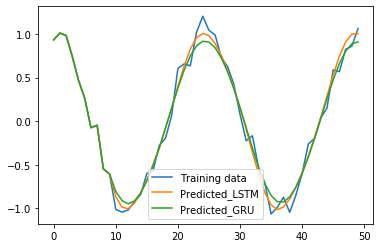

In [15]:
#次の値の予測

predicted_lstm = x[0].reshape(-1) 
predicted_gru = x[0].reshape(-1) 

for i in range(0, n_sample):
    y_lstm = model_lstm.predict(predicted_lstm[-n_rnn:].reshape(1, n_rnn, 1))
    predicted_lstm = np.append(predicted_lstm, y_lstm[0][0])
    y_gru = model_gru.predict(predicted_gru[-n_rnn:].reshape(1, n_rnn, 1))
    predicted_gru = np.append(predicted_gru, y_gru[0][0])

plt.plot(np.arange(len(cos_data)), cos_data, label="Training data")
plt.plot(np.arange(len(predicted_lstm)), predicted_lstm, label="Predicted_LSTM")
plt.plot(np.arange(len(predicted_gru)), predicted_gru, label="Predicted_GRU")
plt.legend()
plt.show()